In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
countries_meta_df = pd.read_csv('countries.csv')
countries_metrics_df = pd.read_csv('countries of the world.csv')

medals_df = pd.read_csv('2024_olympics/medals_total.csv')
populations_df = pd.read_csv('country_populations/countries-table.csv')

In [3]:
medals_df.fillna(0, inplace=True)
medals_df["Score"] = medals_df["Gold Medal"]*3 + medals_df["Silver Medal"]*2 + medals_df["Bronze Medal"]*1

In [4]:
medals_df = medals_df.merge(countries_meta_df[["cioc", "cca3", "name.common"]], left_on='country_code', right_on='cioc', how='left')

In [5]:
df = medals_df.merge(populations_df[["pop2023", "cca3", "country"]], on='cca3', how='left')

In [6]:
from sklearn.preprocessing import MinMaxScaler

df["Score per Capita"] = df["Score"] / df["pop2023"]

scaler = MinMaxScaler((0, 100))
df["Score per Capita (adjusted)"] = scaler.fit_transform(df[["Score per Capita"]]).round(2)

df.sort_values("Score per Capita (adjusted)", ascending=False, inplace=True)

## Linear Model

In [51]:
countries_metrics_df

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,259.5,10.00,15.00,75.00,2.0,22.46,3.27,NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,497.2,2.22,0.00,97.78,3.0,8.71,6.25,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,419.9,0.00,2.98,19.62,800.0,NaN,145.2,16.90,18.97,64.13,3.0,31.67,3.92,0.090,0.280,0.630
223,Western Sahara,NORTHERN AFRICA,273008,266000,1.0,0.42,NaN,NaN,NaN,NaN,NaN,0.02,0.00,99.98,1.0,NaN,NaN,NaN,NaN,0.400
224,Yemen,NEAR EAST,21456188,527970,40.6,0.36,0.00,61.50,800.0,50.2,37.2,2.78,0.24,96.98,1.0,42.89,8.30,0.135,0.472,0.393
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,15.3,0.00,0.00,88.29,800.0,80.6,8.2,7.08,0.03,92.90,2.0,41.00,19.93,0.220,0.290,0.489


In [41]:
countries_metrics_df["Country"] = countries_metrics_df["Country"].str.strip()

for col in countries_metrics_df.columns[2:]:
    if countries_metrics_df[col].dtype == 'str' or countries_metrics_df[col].dtype == 'object':
        countries_metrics_df[col] = countries_metrics_df[col].str.replace(",", ".")
        countries_metrics_df[col] = pd.to_numeric(countries_metrics_df[col], errors='coerce')

In [43]:
tokyo = pd.read_excel("2020_olympics/Medals.xlsx")

/Users/matei/anaconda3/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [44]:
tokyo["Score"] = tokyo["Gold"]*3 + tokyo["Silver"]*2 + tokyo["Bronze"]*1

In [45]:
common_names = [x for x in tokyo["Team/NOC"].values if x in countries_meta_df["name.common"].values]
official_names = set([x for x in tokyo["Team/NOC"].values]) - set(common_names)


common_df = tokyo[tokyo["Team/NOC"].isin(common_names)]
official_df = tokyo[tokyo["Team/NOC"].isin(official_names)]

common_df = common_df.merge(countries_meta_df[["name.common", "name.official"]], left_on='Team/NOC', right_on='name.common', how='left')
official_df = official_df.merge(countries_meta_df[["name.common", "name.official"]], left_on='Team/NOC', right_on='name.official', how='left')

In [46]:
tokyo_lm = pd.concat([common_df, official_df])
tokyo_lm = tokyo_lm.merge(countries_metrics_df, left_on='name.common', right_on='Country', how='left')
tokyo_lm = tokyo_lm.dropna(how='any')
tokyo_lm

,Rank,Team/NOC,Gold,Silver,Bronze,Total,Rank by Total,Score,name.common,name.official,...,Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,3,Japan,27,14,17,58,5,126,Japan,Japan,...,461.2,12.19,0.96,86.85,3.0,9.37,9.16,0.017,0.258,0.725
1,6,Australia,17,7,22,46,6,87,Australia,Commonwealth of Australia,...,565.5,6.55,0.04,93.41,1.0,12.14,7.51,0.038,0.262,0.700
2,7,Netherlands,10,12,14,36,9,68,Netherlands,Kingdom of the Netherlands,...,460.8,26.71,0.97,72.32,3.0,10.90,8.68,0.021,0.244,0.736
3,8,France,10,12,11,33,10,65,France,French Republic,...,586.4,33.53,2.07,64.40,4.0,11.99,9.14,0.022,0.214,0.764
4,9,Germany,10,11,16,37,8,68,Germany,Federal Republic of Germany,...,667.9,33.85,0.59,65.56,3.0,8.25,10.62,0.009,0.296,0.695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,86,Kuwait,0,0,1,1,77,1,Kuwait,State of Kuwait,...,211.0,0.73,0.11,99.16,1.0,21.94,2.41,0.004,0.479,0.516
81,1,United States of America,39,41,33,113,1,232,United States,United States of America,...,898.0,19.13,0.22,80.65,3.0,14.14,8.26,0.010,0.204,0.787
82,2,People's Republic of China,38,32,18,88,2,196,China,People's Republic of China,...,266.7,15.40,1.25,83.35,1.5,13.25,6.97,0.125,0.473,0.403
87,27,Islamic Republic of Iran,3,2,2,7,33,15,Iran,Islamic Republic of Iran,...,276.4,8.72,1.39,89.89,1.0,17.00,5.55,0.116,0.424,0.460


In [91]:
from sklearn.linear_model import LinearRegression

features = ["Population", "Pop. Density (per sq. mi.)", "Net migration", "GDP ($ per capita)", "Literacy (%)", "Arable (%)", "Crops (%)", "Climate", "Deathrate", "Service"]
target = "Score"

X = tokyo_lm[features]
y = tokyo_lm[target]

lm = LinearRegression()
lm.fit(X, y)

LinearRegression()

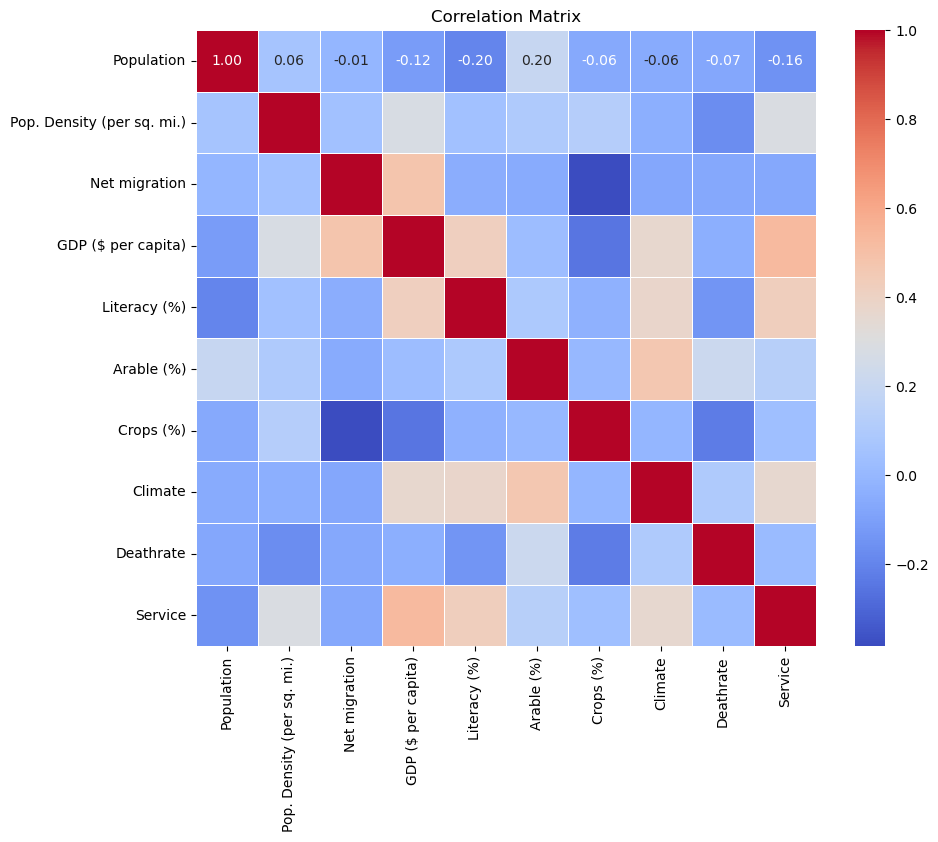

In [92]:
correlation_matrix = tokyo_lm[features].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set the title for the heatmap
plt.title('Correlation Matrix')

# Display the heatmap
plt.show()

In [93]:
pd.DataFrame({"Feature": features, "Coefficient": lm.coef_}).sort_values("Coefficient", ascending=False)

,Feature,Coefficient
9,Service,3.706902e+01
4,Literacy (%),3.006396e-01
5,Arable (%),1.716180e-02
3,GDP ($ per capita),1.552859e-03
0,Population,1.183788e-07
1,Pop. Density (per sq. mi.),-4.069483e-02
8,Deathrate,-4.834352e-02
6,Crops (%),-1.278727e-01
2,Net migration,-5.919722e-01
7,Climate,-2.974101e+00


In [106]:
predictions

array([  30.42338087,   47.85842077,   66.62247228, -190.35517244,
         50.51070627,   18.17127965,   21.59661526,   46.82919012,
         55.26440635,   15.807658  ,  -28.73099261,   20.73236017,
         57.74449166,   51.73612005,   57.55293666,   50.04979952,
         68.10449688,   16.31822616,   20.44568364,   35.83118724,
         48.6888702 ,    2.92484092,   11.86459333,   19.25008618,
         76.00082624,   56.67633392,   13.75679914,   33.0337351 ,
         14.96448128,   33.50032974,  -28.73099261,   28.75040187,
         50.03704037,   10.3128305 ,   16.5898335 ,   11.2320434 ,
         35.01631814,   21.04989517,   11.27226948,   45.46688477,
          6.78679505,   -7.16206451,  -28.73099261])

In [107]:
df_temp = df.copy()

df_temp = df_temp.merge(countries_metrics_df, left_on='country', right_on='Country', how='left')
df_temp["Population"] = df_temp["pop2023"].mean()
predictions = lm.predict(df_temp[features].fillna(0))

In [110]:
df["Lm_Score"] = scaler.fit_transform(predictions.reshape(-1, 1)).round(2)

In [155]:
df.dropna(how='any', inplace=True)

df["Orginal Rank"] = (df["Score"].rank(ascending=False)).astype(int)
df["Per Capita Rank"] = (df["Score per Capita"].rank(ascending=False)).astype(int)
df["LM Rank"] = (df["Lm_Score"].rank(ascending=False)).astype(int)


In [156]:
df_final = df.loc[:, ["country", "Score", "Score per Capita (adjusted)", "Lm_Score", "Orginal Rank", "Per Capita Rank", "LM Rank", ""]]

In [175]:
df_final.sort_values("Lm_Score", ascending=False, inplace=True)

In [ ]:
tempa = df_final[:-1]["Lm_Score"].values.reshape(-1, 1)
temp = scaler.fit_transform(tempa)


In [192]:
df_final["Lm_Score"] = np.round(np.append(temp.flatten(), 0), 2)

In [193]:
df_final

,country,Score,Score per Capita (adjusted),Lm_Score,Orginal Rank,Per Capita Rank,LM Rank
5,United States,45.0,6.14,100.00,1,25,1
8,Canada,12.0,14.43,92.47,9,17,2
2,Australia,27.0,47.78,91.05,5,3,3
22,Sweden,4.0,17.59,82.58,16,13,4
7,Italy,21.0,16.65,82.38,8,15,5
39,Switzerland,1.0,5.26,81.54,38,26,6
3,France,37.0,26.70,80.19,2,9,7
6,United Kingdom,25.0,17.23,76.83,6,14,8
14,Ireland,4.0,36.99,75.66,16,5,9
13,Belgium,4.0,15.97,75.23,16,16,10


In [227]:
df_final2 = df_final.merge(countries_metrics_df[["Region", "Country"]], left_on='country', right_on='Country', how='left')

df_final2.loc[39:41, "Region"] = "ASIA (EX. NEAR EAST) "

In [228]:
df_final2.loc[1]

country                                                     Canada
Score                                                         12.0
Score per Capita (adjusted)                                  14.43
Lm_Score                                                     92.47
Orginal Rank                                                     9
Per Capita Rank                                                 17
LM Rank                                                          2
Region                         NORTHERN AMERICA                   
Country                                                     Canada
Name: 1, dtype: object

In [229]:
df_final2["Region"] = df_final2["Region"].str.strip()

In [230]:
df_final2["Region"] = df_final2["Region"].str.replace("ASIA (EX. NEAR EAST)", "ASIA").replace("NEAR EAST", "ASIA").replace("WESTERN EUROPE", "EUROPE").replace("EASTERN EUROPE", "EUROPE").replace("NORTHERN AFRICA", "AFRICA").replace("SUB-SAHARAN AFRICA", "AFRICA").replace("LATIN AMER. & CARIB", "SOUTH AMERICA")

In [232]:
df_final2.loc[24, "Region"] = "EUROPE"
df_final2.loc[26, "Region"] = "EUROPE"
df_final2.loc[28, "Region"] = "EUROPE"
df_final2.loc[29, "Region"] = "EUROPE"
df_final2.loc[30, "Region"] = "ASIA"
df_final2.loc[31, "Region"] = "ASIA"
df_final2.loc[34, "Region"] = "EUROPE"

In [252]:
df_final2.to_csv("draft1_data.csv", index=False)

In [250]:
from dash import Dash, html, dcc, callback, Output, Input, dash_table
import plotly.express as px

app = Dash()

app.layout = [
    html.H1(children='2024 Paris Olympics'),
    dcc.RadioItems(options=['Original Score', 'Per Capita Score', 'Controlling for Population Score'], value='Original Score', id='controls-and-radio-item'),
    dcc.Graph(figure={}, id='controls-and-graph')
]

@callback(
    Output(component_id='controls-and-graph', component_property='figure'),
    Input(component_id='controls-and-radio-item', component_property='value')
)
def update_graph(col_chosen):
    map_dict = {'Original Score': 'Score', 'Per Capita Score': 'Score per Capita (adjusted)', 'Controlling for Population Score': 'Lm_Score'}

    df_graph = df_final2.sort_values(map_dict[col_chosen])
    fig = px.bar(df_graph, x='country', y=map_dict[col_chosen], color=df_graph["Region"], category_orders={"Region": ["EUROPE", "NORTHERN AMERICA", "SOUTH AMERICA", "ASIA", "AFRICA", "OCEANIA"]})

    fig.update_layout(title='Olympic Medals Score by Country', xaxis_title='Country', yaxis_title='Score')

    return fig

if __name__ == '__main__':
    app.run(debug=True)
